In [8]:
import pyodbc
import pandas as pd
import time
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt
# import plotly

%matplotlib inline
# plotly.offline.init_notebook_mode(connected=False)

table_prefix = 'poincare'
limit = 1000
control_limit = 100
chunk = True

# minimum time in days between enrollment and outcome
minimum_training_period = 730

user = 'bkb12'

creds_file = "/home/bkb12/creds.txt" 
creds = lines = [line.rstrip('\n') for line in open(creds_file)]

connection_string = ("Driver={ODBC Driver 17 for SQL Server};" + 
                     "server=" + creds[0] + ";" +
                     "domain=" + creds[1] + ";" +  
                     "database=" + creds[2] + ";" +
                     "uid=" + creds[3]  + ";" +
                     "pwd=" + creds[4] + ";" +
                     "ssl=require;")

cn = pyodbc.connect(connection_string, autocommit=True)
cursor = cn.cursor()

In [54]:
facts_sql = ("SELECT MemberNum, Count(1) FROM bkb12.dbo.poincare_diagnoses GROUP BY MemberNum;")
fact = pd.read_sql(facts_sql, cn)
print(fact.head())

        MemberNum    
0       753464625  25
1  25951960583725  19
2  19730729538225  69
3  10211530488525  79
4  18428615348525  27


In [56]:
fact.columns = ['MemberNum', 'FactCount']
print(fact.describe())

          MemberNum      FactCount
count  7.331500e+05  733150.000000
mean   8.124319e+13      22.380820
std    2.837602e+15      28.700785
min    1.484625e+06       1.000000
25%    1.011959e+13       4.000000
50%    1.838440e+13      13.000000
75%    2.595808e+13      29.000000
max    1.212283e+17     565.000000


In [9]:
demographics_sql = ("SELECT BirthYearMinus1900, GENDER FROM bkb12.dbo.poincare_members pc " +
                    "JOIN gmw3.dbo.MemberDemographics md " +
                    "ON pc.MemberNum = md.MemberNum;")

dem = pd.read_sql(demographics_sql, cn)

In [12]:
dem['Age'] = 2016-(1900+dem['BirthYearMinus1900'])
print(dem.head(1000))                                     

     BirthYearMinus1900 GENDER   age   Age
0                  64.0      M  52.0  52.0
1                  64.0      M  52.0  52.0
2                  64.0      M  52.0  52.0
3                  64.0      M  52.0  52.0
4                  64.0      M  52.0  52.0
5                  64.0      M  52.0  52.0
6                  64.0      M  52.0  52.0
7                  64.0      M  52.0  52.0
8                  64.0      M  52.0  52.0
9                  64.0      M  52.0  52.0
10                 64.0      M  52.0  52.0
11                 64.0      M  52.0  52.0
12                 64.0      M  52.0  52.0
13                 64.0      M  52.0  52.0
14                 64.0      M  52.0  52.0
15                 64.0      M  52.0  52.0
16                 64.0      M  52.0  52.0
17                 64.0      M  52.0  52.0
18                 64.0      M  52.0  52.0
19                 64.0      M  52.0  52.0
20                 64.0      M  52.0  52.0
21                 64.0      M  52.0  52.0
22         

In [13]:
print(dem['Age'].describe())
print(dem['GENDER'].value_counts()[:2])

count    9.847813e+06
mean     4.866673e+01
std      2.268095e+01
min      0.000000e+00
25%      3.200000e+01
50%      5.100000e+01
75%      6.500000e+01
max      1.160000e+02
Name: Age, dtype: float64
F    5868902
M    3978803
Name: GENDER, dtype: int64


In [14]:
start_time = time.time()
cursor.execute("IF OBJECT_ID('" + user + ".dbo." + table_prefix + "_diagnosis', 'U') " +  
               "IS NOT NULL DROP TABLE " + user + ".dbo." + table_prefix + "_diagnosis;")

sql = ("SELECT t1_icd, t2_icd, t2.count_total, count_move, " +
       "CAST(count_move AS float)/CAST(t2.count_total AS float) as ratio FROM bkb12.dbo.poincare_relations " +
       "LEFT JOIN (SELECT DiagnosisCode, COUNT(1) count_total FROM bkb12.dbo.poincare_diagnoses GROUP BY DiagnosisCode) t2 "+
       "ON t1_icd = t2.DiagnosisCode " +
       "WHERE CAST(count_move AS float)/CAST(t2.count_total AS float) > 0.02 AND count_move > 10;")

print(sql)

if chunk:
    chunk_list = []
    i = 0
    for c in pd.read_sql_query(sql , cn, chunksize=1000000):
        print(i, time.time() - start_time)
        chunk_list.append(c)
        i += 1
    seq = pd.concat(chunk_list)
else:
    seq = pd.read_sql(sql, cn)

print(seq.shape)
print(seq.head())
print(time.time() - start_time)

SELECT t1_icd, t2_icd, t2.count_total, count_move, CAST(count_move AS float)/CAST(t2.count_total AS float) as ratio FROM bkb12.dbo.poincare_relations LEFT JOIN (SELECT DiagnosisCode, COUNT(1) count_total FROM bkb12.dbo.poincare_diagnoses GROUP BY DiagnosisCode) t2 ON t1_icd = t2.DiagnosisCode WHERE CAST(count_move AS float)/CAST(t2.count_total AS float) > 0.02 AND count_move > 10;
0 4.95449686050415
(619215, 5)
   t1_icd   t2_icd  count_total  count_move     ratio
0  054.10    724.5         2950          94  0.031864
1  705.83      311         1193          53  0.044426
2   333.2   079.99          433          17  0.039261
3   J44.1  J45.901          358          17  0.047486
4  780.52   786.05        29951        1569  0.052386
5.032758474349976


In [15]:
import csv
relations = seq[['t1_icd', 't2_icd']]
relations.to_csv('./data/relations_10M.tsv', header=False, sep='\t', index=False, quoting=csv.QUOTE_NONNUMERIC)

In [16]:
relations = pd.read_csv('/home/bkb12/code/PoincareEmbeddings/data/relations_10M.tsv', header=None, sep='\t')
relations[0].value_counts()

518.5       380
440.23      373
584.5       373
349.82      370
518.51      369
348.31      363
730.27      362
196.2       361
785.52      361
V46.11      361
348.5       352
785.4       349
V45.11      348
262         346
785.59      346
995.92      346
428.33      345
284.19      342
996.73      340
403.91      339
852.20      339
730.07      336
730.20      334
284.1       333
428.31      332
518.4       332
428.43      332
995.90      331
518.84      330
428.23      330
           ... 
G95.9         1
Z93.6         1
V18.2         1
M25.431       1
366.44        1
O21.0         1
F12.90        1
672.04        1
368.42        1
301.89        1
M32.19        1
331.19        1
307.43        1
386.54        1
379.33        1
642.92        1
278.4         1
789.5         1
732.2         1
M23.41        1
E883.0        1
V48.3         1
758.5         1
M25.361       1
641.20        1
S61.412A      1
464.30        1
E902.0        1
203.80        1
648.14        1
Name: 0, Length: 9753, d

In [ ]:
! ./poincare-embedding/work/poincare_embedding ./data/relations_10M.tsv ./data/relations_10M_embeddings.tsv -d 2 -t 16 -e 100 -l 0.01 -L 0.000001 -n 20 -s 0



In [17]:
import plotly.offline as offline
import plotly.graph_objs as go
from matplotlib import cm
import pandas as pd
from collections import Counter
import numpy as np

from utils import transitive_isometry, poincare_icd_2d_visualization

%matplotlib inline
offline.init_notebook_mode()

icd_embeddings_file = './data/relations_10M_embeddings.tsv'
icd_tree_file = './data/relations_10M.tsv'
num_nodes = 100000

icd_embeddings = pd.read_csv(icd_embeddings_file, header=None, sep="\t")
icd_embeddings.columns = ['icd', 'x', 'y']


# print(icd_embeddings.loc[icd_embeddings['icd'] == 'center'])

icd_tree = pd.read_csv(icd_tree_file, header=None, sep="\t")
icd_tree.columns = ['parent', 'child']

figure_title = '10 Million Members'

print(icd_embeddings.shape)
icd_embeddings = icd_embeddings[icd_embeddings['icd'].str.get(0).str.isdigit()]                     
print(icd_embeddings.shape)
icd_embeddings['x'] = icd_embeddings['x'].astype(float)
icd_embeddings['y'] = icd_embeddings['y'].astype(float)

all_codes = pd.read_csv('./data/icd9/allcodes.csv', sep="|")
majors = pd.read_csv('./data/icd9/majors.csv', sep="|")
chapters = pd.read_csv('./data/icd9/chapters.csv', sep="|").transpose()
sub_chapters = pd.read_csv('./data/icd9/subchapters.csv', sep="|").transpose()

df = pd.DataFrame(columns=['parent', 'child'])
# print(all_codes.head(3))

# handle chapters
chapters = chapters.reset_index()
chapters.columns = ['name', 'start', 'end']
chapters['range'] = 'c_' + chapters['start'].map(str) + '_' + chapters['end'].map(str)

chap_name_dict = dict(zip(chapters['name'], chapters['range']))
chap_range_dict = dict(zip(chapters['range'], chapters['name']))

sub_chapters = sub_chapters.reset_index()
sub_chapters.columns = ['name', 'start', 'end']
sub_chapters['range'] = 's_' + sub_chapters['start'].map(str) + '_' + sub_chapters['end'].map(str)

subchap_name_dict = dict(zip(sub_chapters['name'], sub_chapters['range']))
subchap_range_dict = dict(zip(sub_chapters['range'], sub_chapters['name']))

print(chapters.shape)
chapters = chapters[:17]
print(chapters.shape)

print(majors.shape)
majors = majors[:928]
print(majors.shape)

sub_chapters = sub_chapters[:119]

chapters_start = chapters['start'].astype(int).values
print(chapters_start)

nodes_colors = []
nodes_size = []
for i, icd in icd_embeddings.iterrows():
    if icd['icd'] == 'center':
        nodes_colors.append(0)
        continue
    else:
        code = icd['icd']
        nodes_size.append(6)
    nodes_colors.append(np.argmin(chapters_start <= float(code)))

print(icd_embeddings.shape, icd_tree.shape)
icd_tree_set = set(icd_tree.itertuples(index=False))

vis = poincare_icd_2d_visualization(icd_embeddings, [],
                                    nodes_colors = nodes_colors,
                                    nodes_size = nodes_size,
                                    figure_title=figure_title, 
#                                     center='278.0',
                                    num_nodes=num_nodes, chapter_names=True)
                                    #show_node_labels=show_node_labels)
offline.iplot(vis)#, image='png')

(9988, 3)
(6110, 3)
(19, 4)
(17, 4)
(1234, 1)
(928, 1)
[  1 140 240 280 290 320 390 460 520 580 630 680 710 740 760 780 800]
(6110, 3) (619215, 2)


In [18]:
icd_embeddings.set_index('icd', inplace=True)

In [2]:
from sklearn.metrics.pairwise import pairwise_distances, euclidean_distances
from utils import transitive_isometry, poincare_icd_2d_visualization, hyperbolic_distance

In [20]:
hyperbolic_radius = []
euclidean_radius = []

euclidean_radius = euclidean_distances(icd_embeddings.values, np.array([0, 0]).reshape(1, -1))

for i, p in icd_embeddings.iterrows():
    hyperbolic_radius.append(hyperbolic_distance(p.values, np.array([0, 0])))

In [21]:
print(seq.head())
frequency = seq.groupby('t1_icd')[['count_total']].sum()

   t1_icd   t2_icd  count_total  count_move     ratio
0  054.10    724.5         2950          94  0.031864
1  705.83      311         1193          53  0.044426
2   333.2   079.99          433          17  0.039261
3   J44.1  J45.901          358          17  0.047486
4  780.52   786.05        29951        1569  0.052386


               x         y  hyperbolic_radius  euclidean_radius
icd                                                            
790.5  -0.349615 -0.576626           1.637303          0.674335
474.00  0.864401  0.428343           4.019522          0.964711
786.50  0.210635 -0.133169           0.509121          0.249201
716.95  0.566758 -0.821296           6.843059          0.997869
429.3  -0.109806 -0.637187           1.538796          0.646579


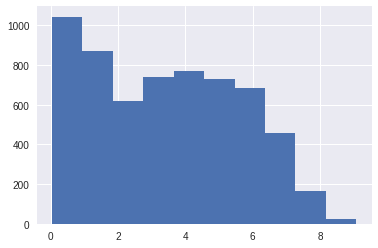

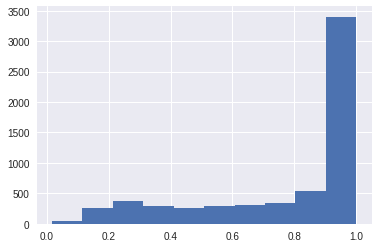

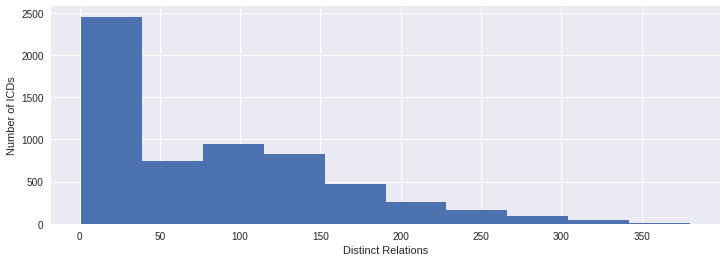

In [50]:
import matplotlib.pyplot as plt
%matplotlib inline

embeddings_plus = icd_embeddings.copy(deep=True)
embeddings_plus['hyperbolic_radius'] = hyperbolic_radius
embeddings_plus['euclidean_radius'] = euclidean_radius
print(embeddings_plus.head())

embeddings_plus['hyperbolic_radius'].hist()
plt.show()
embeddings_plus['euclidean_radius'].hist()
plt.show()

# add frequency of icd, move and ratio
frequency = seq.groupby('t1_icd')[['count_total', 'count_move']].sum()
embeddings_plus = pd.merge(embeddings_plus, frequency, left_index=True, right_on='t1_icd')
embeddings_plus['ratio'] = embeddings_plus['count_move'] / embeddings_plus['count_total']  

# count appearances in relations
embeddings_plus['distinct_relations'] = relations[0].value_counts()
ax = embeddings_plus['distinct_relations'].hist(figsize=[12, 4])
ax.set_xlabel("Distinct Relations")
ax.set_ylabel("Number of ICDs")
plt.show()

                            OLS Regression Results                            
Dep. Variable:            count_total   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     134.4
Date:                Sun, 05 Aug 2018   Prob (F-statistic):           9.67e-31
Time:                        15:21:16   Log-Likelihood:                -91153.
No. Observations:                6023   AIC:                         1.823e+05
Df Residuals:                    6022   BIC:                         1.823e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
hyperbolic_radius  3.306e+04   2852.05

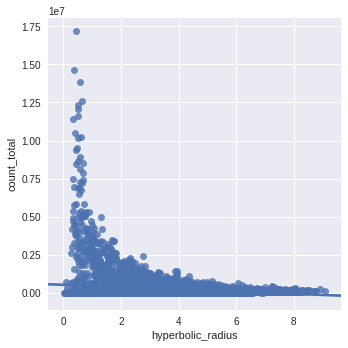

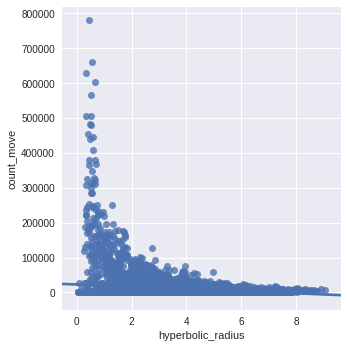

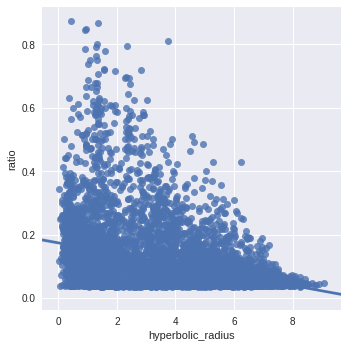

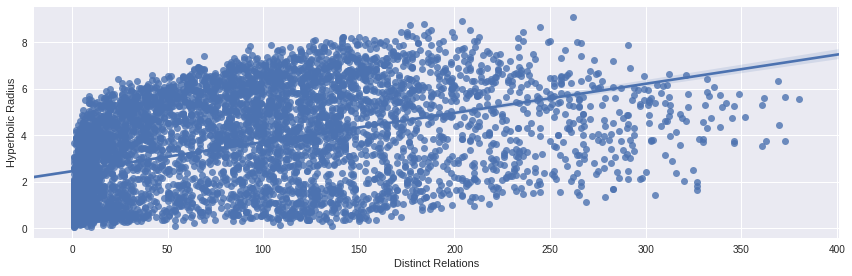

                            OLS Regression Results                            
Dep. Variable:      hyperbolic_radius   R-squared:                       0.609
Model:                            OLS   Adj. R-squared:                  0.609
Method:                 Least Squares   F-statistic:                     9394.
Date:                Sun, 05 Aug 2018   Prob (F-statistic):               0.00
Time:                        15:21:19   Log-Likelihood:                -14195.
No. Observations:                6023   AIC:                         2.839e+04
Df Residuals:                    6022   BIC:                         2.840e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
distinct_relations     0.0284      0

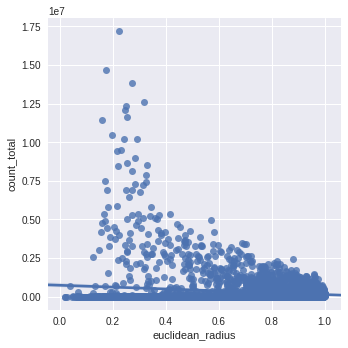

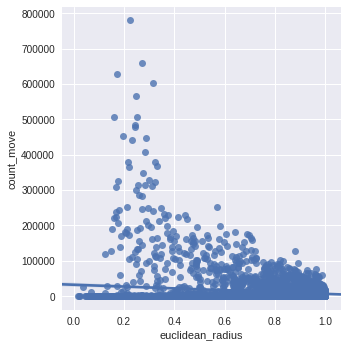

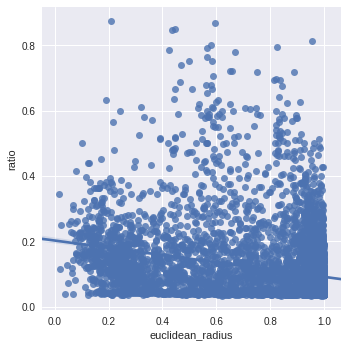

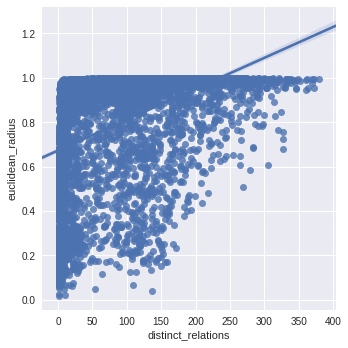

In [39]:
import seaborn as sns
import statsmodels.api as sm

sns.lmplot(data=embeddings_plus, x='hyperbolic_radius', y='count_total')
results = sm.OLS(embeddings_plus['count_total'], 
                 embeddings_plus['hyperbolic_radius']).fit()
print(results.summary())

sns.lmplot(data=embeddings_plus, x='hyperbolic_radius', y='count_move')
results = sm.OLS(embeddings_plus['count_move'], 
                 embeddings_plus['hyperbolic_radius']).fit()
print(results.summary())

sns.lmplot(data=embeddings_plus, x='hyperbolic_radius', y='ratio')
results = sm.OLS(embeddings_plus['ratio'], 
                 embeddings_plus['hyperbolic_radius']).fit()
print(results.summary())


ax = sns.lmplot(data=embeddings_plus, x='distinct_relations', y='hyperbolic_radius', size=4, aspect=3)
ax.set(xlabel='Distinct Relations', ylabel='Hyperbolic Radius')
plt.show()

results = sm.OLS(embeddings_plus['hyperbolic_radius'], 
                 embeddings_plus['distinct_relations']).fit()
print(results.summary())

sns.lmplot(data=embeddings_plus, x='euclidean_radius', y='count_total')
results = sm.OLS(embeddings_plus['count_total'], 
                 embeddings_plus['euclidean_radius']).fit()
print(results.summary())

sns.lmplot(data=embeddings_plus, x='euclidean_radius', y='count_move')
results = sm.OLS(embeddings_plus['count_move'], 
                 embeddings_plus['euclidean_radius']).fit()
print(results.summary())

sns.lmplot(data=embeddings_plus, x='euclidean_radius', y='ratio')
results = sm.OLS(embeddings_plus['ratio'], 
                 embeddings_plus['euclidean_radius']).fit()
print(results.summary())

sns.lmplot(data=embeddings_plus, x='distinct_relations', y='euclidean_radius')
results = sm.OLS(embeddings_plus['euclidean_radius'], 
                 embeddings_plus['distinct_relations']).fit()
print(results.summary())

In [113]:
print(embeddings_plus.head())

embeddings_plus['icd'] = embeddings_plus.index.values
embeddings_plus['major'] = embeddings_plus['icd'].str.split('.', expand=True)

chapters = pd.read_csv('./data/icd9/chapters.csv', sep="|").transpose()[:17]
chapters_start = chapters['start'].astype(int).values
embeddings_plus['chapter'] = embeddings_plus['major'].map(lambda m: np.argmin(chapters_start <= int(m)))

sub_chapters = pd.read_csv('./data/icd9/subchapters.csv', sep="|").transpose()[:119]
sub_chapters_start = sub_chapters['start'].astype(int).values
embeddings_plus['sub_chapter'] = embeddings_plus['major'].map(lambda m: np.argmin(sub_chapters_start <= int(m)))

# embeddings_plus['sub_chapter'] = 
print(embeddings_plus.head())

               x         y  hyperbolic_radius  euclidean_radius  count_total  \
t1_icd                                                                         
790.5  -0.349615 -0.576626           1.637303          0.674335      1187110   
474.00  0.864401  0.428343           4.019522          0.964711       329103   
786.50  0.210635 -0.133169           0.509121          0.249201     12365250   
716.95  0.566758 -0.821296           6.843059          0.997869       212646   
429.3  -0.109806 -0.637187           1.538796          0.646579      3211950   

        count_move     ratio  distinct_relations     icd major  chapter  \
t1_icd                                                                    
790.5        47954  0.040396                 170   790.5   790       16   
474.00       15162  0.046071                  81  474.00   474        8   
786.50      566412  0.045807                 150  786.50   786       16   
716.95        9918  0.046641                 183  716.95   716  

In [3]:
distance_matrix = pairwise_distances(embeddings_plus[['x', 'y']], icd_embeddings[['x', 'y']], 
                                     metric='euclidean') #switch back to hyperbolic, just testing

print(distance_matrix)
np.save('./data/distance_matrix.npy', distance_matrix)

NameError: name 'embeddings_plus' is not defined

In [4]:
embeddings_clear = embeddings_plus.copy(deep=True)
embeddings_clear.reset_index(inplace=True)
in_major = []
out_major = []

in_subchapter = []
out_subchapter = []

in_chapter = []
out_chapter = []

for i, icd in embeddings_clear.iterrows():
    indices = embeddings_clear.index[embeddings_clear['major'] == icd['major']].tolist()
    if len(indices) > 1:
        in_major.append(np.mean(distance_matrix[i, indices]))
    
        out_indices = embeddings_clear.index[embeddings_clear['major'] != icd['major']].tolist()
        out_major.append(np.mean(distance_matrix[i, out_indices]))
        
    indices = embeddings_clear.index[embeddings_clear['sub_chapter'] == icd['sub_chapter']].tolist()
    if len(indices) > 1:
        in_subchapter.append(np.mean(distance_matrix[i, indices]))
    
        out_indices = embeddings_clear.index[embeddings_clear['sub_chapter'] != icd['sub_chapter']].tolist()
        out_subchapter.append(np.mean(distance_matrix[i, out_indices]))
        
    indices = embeddings_clear.index[embeddings_clear['chapter'] == icd['chapter']].tolist()
    if len(indices) > 1:
        in_chapter.append(np.mean(distance_matrix[i, indices]))
    
        out_indices = embeddings_clear.index[embeddings_clear['chapter'] != icd['chapter']].tolist()
        out_chapter.append(np.mean(distance_matrix[i, out_indices]))

NameError: name 'embeddings_plus' is not defined

In [ ]:
print(np.mean(in_major), np.mean(out_major))
print(np.std(in_major), np.std(out_major))
print(np.mean(in_subchapter), np.mean(out_subchapter))
print(np.std(in_subchapter), np.std(out_subchapter))
print(np.mean(in_chapter), np.mean(out_chapter))
print(np.std(in_chapter), np.std(out_chapter))
# sns.distplot(in_major)
# sns.distplot(out_major)
# plt.show()
# sns.distplot(in_subchapter)
# sns.distplot(out_subchapter)
# plt.show()
# sns.distplot(in_chapter)
# sns.distplot(out_chapter)